In [1]:
from google.colab import drive
drive.mount('My_Drive')

Mounted at My_Drive


In [2]:
'''Importing Libraries'''
import argparse
from argparse import ArgumentParser
import glob
import cv2
import re
import os, glob, datetime
import numpy as np
import tensorflow as tf
import numpy as np
import time
import math
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract, Reshape
from keras.models import Model, load_model
from tensorflow.python.keras.utils import conv_utils
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import keras.backend as K

import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread, imsave
from PIL import Image

In [9]:
# Select the path of the directory properly to give access to the models, datasets and results
parser = argparse.ArgumentParser()
# choose if needed
parser.add_argument('--model', default='DIVA2D', type=str, help='choose a type of model')

parser.add_argument('--set_dir', default='/content/My_Drive/MyDrive/CNRS Research/test_data', type=str, help='directory of test dataset')
parser.add_argument('--set_names_Speckled', default='/content/My_Drive/MyDrive/CNRS Research/test_data/TEST_FOCUS', type=str, help='name of the speckled test dataset')
parser.add_argument('--set_names_clean', default='/content/My_Drive/MyDrive/CNRS Research/test_data/TEST_CLEAN', type=str, help='name of the clean test dataset') # if you have it for calculating PSNR SSIM
parser.add_argument('--kernel_size', default=5, type=int, help='Hamiltonian kernel size')
parser.add_argument('--model_dir', default=os.path.join('/content/My_Drive/MyDrive/CNRS Research/Deep_DeQuIP_300_FOCUS'), type=str, help='directory of the model')

parser.add_argument('--model_name', default='300_F_model_060.hdf5', type=str, help='the model name')
parser.add_argument('--result_dir', default='/content/My_Drive/MyDrive/CNRS Research/Deep_DeQuIP_300_FOCUS/results', type=str, help='directory of results')
parser.add_argument('--save_result', default=1, type=int, help='save the denoised image, 1 or 0')

parser.add_argument('-f', '--file', required=False)
args = parser.parse_args()



print(args.model_name)

300_F_model_060.hdf5


In [10]:
'''Utility Functions'''
def to_tensor(img):
    if img.ndim == 2:
        return img[np.newaxis,...,np.newaxis]
    elif img.ndim == 3:
        return np.moveaxis(img,2,0)[...,np.newaxis]

def from_tensor(img):
    return np.squeeze(np.moveaxis(img[...,0],0,-1))

def log(*args,**kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"),*args,**kwargs)

def save_result(result,path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt','.dlm'):
        np.savetxt(path,result,fmt='%2.4f')
    else:
        imsave(path,(np.clip(result,0,1) * 255).astype(np.uint8))


def show(x,title=None,cbar=False,figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x,interpolation='nearest',cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()

def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = np.sqrt(np.mean(diff ** 2.))

    return 20 * np.log10(1. / rmse)


def snr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)

    diff = ref_data - target_data
    diff = diff.flatten('C')
    target_data = target_data.flatten('C')

    rmse_diff = np.sqrt(np.mean(diff ** 2.))
    rmse_target = np.sqrt(np.mean(target_data ** 2.))

    return 20 * np.log10(rmse_target / rmse_diff)

In [11]:
'''Model Architecture'''
class Hamiltonian_Conv2D(Conv2D):

    def __init__(self, filters, kernel_size, kernel_3=None, kernel_4=None, activation=None, **kwargs):

        self.rank = 2               # Dimension of the kernel
        self.num_filters = filters  # Number of filter in the convolution layer
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, self.rank, 'kernel_size')
        self.kernel_3 = kernel_3    # Weights from original potential
        self.kernel_4 = kernel_4    # Weights from interaction

        super(Hamiltonian_Conv2D, self).__init__(self.num_filters, self.kernel_size,
              activation=activation, use_bias=False, **kwargs)

    def build(self, input_shape):
        if K.image_data_format() == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                     'should be defined. Found `None`.')

        #don't use bias:
        self.bias = None

        #consider the layer built
        self.built = True


        # Define nabla operator
        weights_1 = tf.constant([[ 2.,-1., 0.],
                                 [-1., 4.,-1.],
                                 [ 0.,-1., 2.]])


        weights_1 = tf.reshape(weights_1 , [3,3, 1])
        weights_1 = tf.repeat(weights_1 , repeats=self.num_filters, axis=2)
        #print('kernel shape of weights_1:',weights_1.get_shape())

        # Define Weights for h^2/2m  (size should be same as the nabla operator)
        weights_2 = self.add_weight(shape=weights_1.get_shape(),
                                      initializer= 'Orthogonal',
                                      name='kernel_h^2/2m',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        #print('kernel shape of weights_2:',weights_2.get_shape())


        # Define the Hamiltonian kernel
        self.kernel = weights_1*weights_2 + self.kernel_3 + self.kernel_4
        #print('self.kernel',self.kernel.get_shape())

        self.built = True
        super(Hamiltonian_Conv2D, self).build(input_shape)

    # Do the 2D convolution using the Hamiltonian kernel
    def convolution_op(self, inputs, kernel):
        if self.padding == "causal":
            tf_padding = "VALID"  # Causal padding handled in `call`.
        elif isinstance(self.padding, str):
            tf_padding = self.padding.upper()
        else:
            tf_padding = self.padding


        return tf.nn.convolution(
            inputs,
            kernel,
            strides=list(self.strides),
            padding=tf_padding,
            dilations=list(self.dilation_rate),
            name=self.__class__.__name__,
        )

    def call(self, inputs):
        outputs = self.convolution_op(inputs, self.kernel)
        return outputs


def DIVA2D(depth,filters=64,image_channels=1, kernel_size=5, use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=(None,None,image_channels),name = 'input'+str(layer_count))

    # Get the initial patches /initial_patches
    initial_patches = Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'initial_patches')(inpt)
    initial_patches = Activation('relu',name = 'initial_patch_acti')(initial_patches)
    #print(initial_patches.get_shape())

    # interaction layer
    inter = Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'interactions')(initial_patches)
    inter = Activation('relu',name = 'interaction_acti'+str(layer_count))(inter)
    #print(inter.get_shape())


    # Get contributions of the original potential in the Hamiltonian kernel
    ori_poten_kernel = tf.keras.layers.MaxPooling2D (pool_size=(21,21), strides=(15,15), padding='same', name = 'ori_poten_ker', data_format=None )(initial_patches)
    #print('ori_poten_kernel',ori_poten_kernel.get_shape())

    # Get contributions of the interactions in the Hamiltonian kernel
    inter_kernel = tf.keras.layers.MaxPooling2D (pool_size=(21,21), strides=(15,15), padding='same', name = 'inter_ker', data_format=None )(inter)
    #print('inter_kernel',inter_kernel.get_shape())


    # Get projection coefficients of the initial patches on the Hamiltonian kernel
    x = Hamiltonian_Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), kernel_3 = ori_poten_kernel, kernel_4 = inter_kernel, strides=(1,1), activation='relu',
                              kernel_initializer='Orthogonal', padding='same', name = 'proj_coef')(initial_patches)

    #print('coef',x.get_shape())


    # Do Thresholding (depth depends on the noise intensity)
    for i in range(depth):
      layer_count += 1
      x = Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)

      layer_count += 1
      x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
        #x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)

      # Thresholding
      x = Activation('relu',name = 'Thresholding'+str(layer_count))(x)

    # Inverse projection
    x = Conv2D(filters=image_channels, kernel_size=(kernel_size,kernel_size), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'inv_trans')(x)


    # Deconvolution layer
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(args.kernel_size,args.kernel_size), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'deconv'+str(layer_count))(x)
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(args.kernel_size,args.kernel_size), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'deconv'+str(layer_count))(x)
    layer_count += 1
    x = Conv2D(filters=image_channels, kernel_size=(args.kernel_size,args.kernel_size), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'deconv'+str(layer_count))(x)
    layer_count += 1


    x = Subtract(name = 'subtract')([inpt, x])   # input - noise

    model = Model(inputs=inpt, outputs=x)

    return model

2024-05-09 20:34:23: load trained model architecture
1/1 [==============================] - 3s 3s/step
Bmode_training401.png : 2.6034 second
Bmode_training401.png : PNSR 24.1 : SSIM 0.6664 


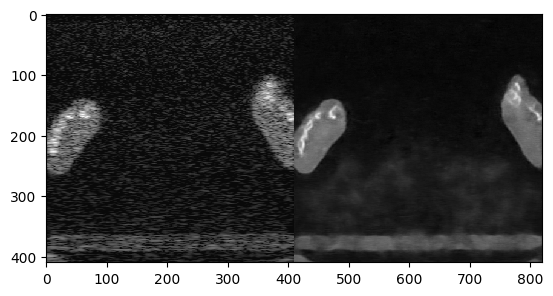

2024-05-09 20:34:27: Dataset: Bmode_training401.png 
  SNR_in = 4.27 dB, PSNR_in = 22.12 dB, SSIM_in = 0.3636
2024-05-09 20:34:27: PSNR = 24.10 dB, SSIM = 0.6664
1/1 [==============================] - 0s 24ms/step
Bmode_training402.png : 0.3657 second
Bmode_training402.png : PNSR 26.2 : SSIM 0.7371 


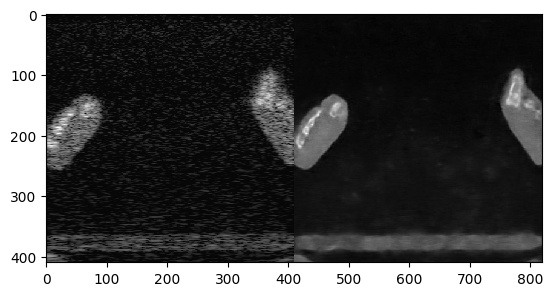

2024-05-09 20:34:28: Dataset: Bmode_training402.png 
  SNR_in = 6.31 dB, PSNR_in = 23.73 dB, SSIM_in = 0.5282
2024-05-09 20:34:28: PSNR = 26.26 dB, SSIM = 0.7371
1/1 [==============================] - 0s 20ms/step
Bmode_training403.png : 0.3645 second
Bmode_training403.png : PNSR 20.9 : SSIM 0.5756 


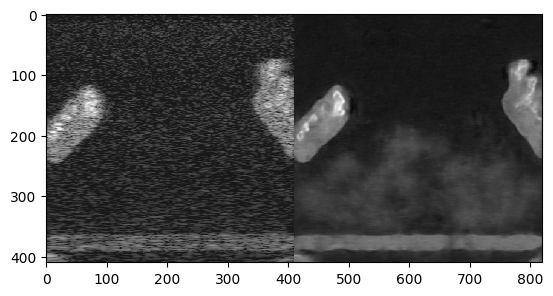

2024-05-09 20:34:29: Dataset: Bmode_training403.png 
  SNR_in = 3.12 dB, PSNR_in = 20.07 dB, SSIM_in = 0.2640
2024-05-09 20:34:29: PSNR = 20.97 dB, SSIM = 0.5756
1/1 [==============================] - 0s 19ms/step
Bmode_training404.png : 0.3589 second
Bmode_training404.png : PNSR 27.7 : SSIM 0.8063 


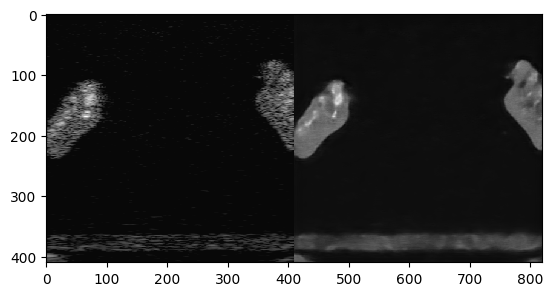

2024-05-09 20:34:31: Dataset: Bmode_training404.png 
  SNR_in = 6.49 dB, PSNR_in = 23.31 dB, SSIM_in = 0.6779
2024-05-09 20:34:31: PSNR = 27.73 dB, SSIM = 0.8063
1/1 [==============================] - 0s 20ms/step
Bmode_training405.png : 0.3645 second
Bmode_training405.png : PNSR 22.6 : SSIM 0.6320 


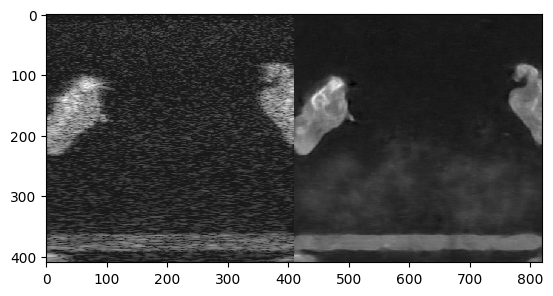

2024-05-09 20:34:32: Dataset: Bmode_training405.png 
  SNR_in = 4.24 dB, PSNR_in = 20.90 dB, SSIM_in = 0.3356
2024-05-09 20:34:32: PSNR = 22.66 dB, SSIM = 0.6320
1/1 [==============================] - 0s 26ms/step
Bmode_training406.png : 0.6915 second
Bmode_training406.png : PNSR 25.8 : SSIM 0.7442 


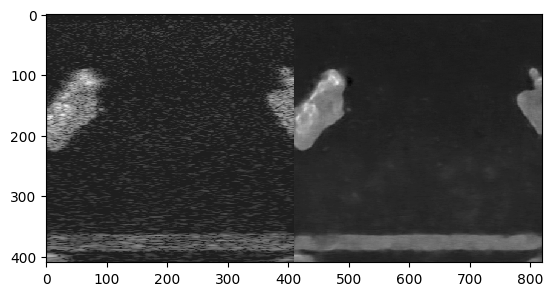

2024-05-09 20:34:34: Dataset: Bmode_training406.png 
  SNR_in = 6.07 dB, PSNR_in = 23.51 dB, SSIM_in = 0.5299
2024-05-09 20:34:34: PSNR = 25.89 dB, SSIM = 0.7442
1/1 [==============================] - 0s 21ms/step
Bmode_training407.png : 0.4511 second
Bmode_training407.png : PNSR 23.4 : SSIM 0.6725 


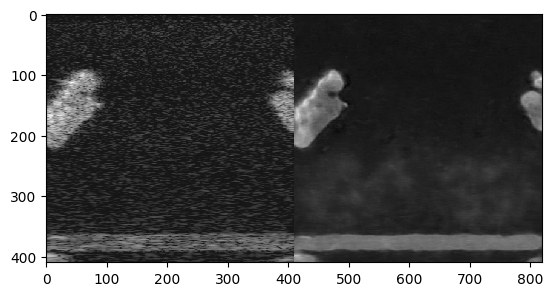

2024-05-09 20:34:35: Dataset: Bmode_training407.png 
  SNR_in = 4.86 dB, PSNR_in = 21.94 dB, SSIM_in = 0.4096
2024-05-09 20:34:35: PSNR = 23.45 dB, SSIM = 0.6725
1/1 [==============================] - 0s 19ms/step
Bmode_training408.png : 0.3598 second
Bmode_training408.png : PNSR 21.9 : SSIM 0.6062 


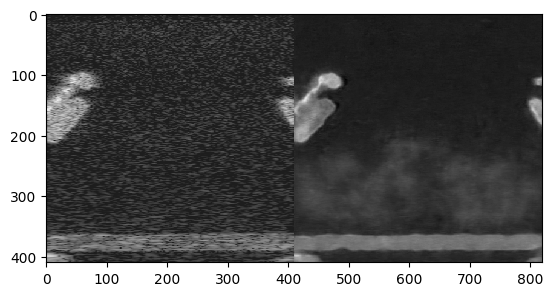

2024-05-09 20:34:37: Dataset: Bmode_training408.png 
  SNR_in = 2.74 dB, PSNR_in = 20.66 dB, SSIM_in = 0.3084
2024-05-09 20:34:37: PSNR = 21.96 dB, SSIM = 0.6062
1/1 [==============================] - 0s 19ms/step
Bmode_training409.png : 0.3626 second
Bmode_training409.png : PNSR 19.5 : SSIM 0.5067 


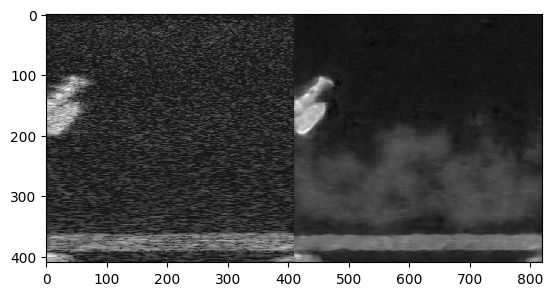

2024-05-09 20:34:38: Dataset: Bmode_training409.png 
  SNR_in = 1.00 dB, PSNR_in = 19.40 dB, SSIM_in = 0.2489
2024-05-09 20:34:38: PSNR = 19.50 dB, SSIM = 0.5067
1/1 [==============================] - 0s 19ms/step
Bmode_training410.png : 0.3607 second
Bmode_training410.png : PNSR 23.1 : SSIM 0.6383 


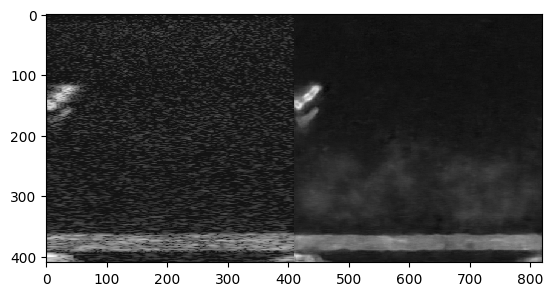

2024-05-09 20:34:40: Dataset: Bmode_training410.png 
  SNR_in = 1.37 dB, PSNR_in = 21.01 dB, SSIM_in = 0.3778
2024-05-09 20:34:40: PSNR = 23.18 dB, SSIM = 0.6383


In [12]:
# Also set 'use_model = False' (which load pretrained models)
use_model = True   # for 'use_model = True', will prepare the network first then load the weights

if __name__ == '__main__':

    if  use_model:
        #choose model depth and filters number
        model = DIVA2D(depth=15,filters=96,image_channels=1,use_bnorm=True)
        model.load_weights(os.path.join(args.model_dir, args.model_name))
        log('load trained model architecture')
    else:
        print('Model- ',args.model)
        model = load_model(os.path.join(args.model_dir, args.model_name),compile=False)
        log('load trained model')

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)

    for im in os.listdir(args.set_names_Speckled):

        if not os.path.exists(os.path.join(args.result_dir,im)):
            os.mkdir(os.path.join(args.result_dir,im))
        snrs_in = []
        psnrs_in = []
        ssims_in = []
        psnrs = []
        ssims = []

        if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):


            # speckled noise case
            noise_type = 'Speckled'

            # read the speckled image
            y = np.array(imread(os.path.join(args.set_names_Speckled,im)), dtype=np.float32) / 255.0

            # read the respective clean image
            last_name = im.split('_')
            #print('im',im)
            #print('last_name',last_name[-1])
            x = np.array(imread(os.path.join(args.set_names_clean,last_name[-1])), dtype=np.float32) / 255.0


            y = y.astype(np.float32)

            y_  = to_tensor(y)
            start_time = time.time()
            x_ = model.predict(y_) # inference
            elapsed_time = time.time() - start_time
            print('%10s : %2.4f second'%(im,elapsed_time))

            x_=from_tensor(x_)

            # calculate for speckled noise
            snr_y = snr(x, y)        # input SNR
            psnr_y = psnr(x, y)      # input PSNR
            ssim_y = ssim(x, y)      # input SSIM
            psnr_x_ = psnr(x, x_)
            ssim_x_ = ssim(x, x_)
            print('%10s : PNSR %2.4s : SSIM %1.4f '%(im,psnr_x_, ssim_x_))



            if args.save_result:
                name, ext = os.path.splitext(im)
                show(np.hstack((y,x_))) # show the image
                save_result(x_,path=os.path.join(args.result_dir,im,name + ext)) # save the despeckled image

                snrs_in.append(snr_y)     # input SNR
                psnrs_in.append(psnr_y)   # input PSNR
                ssims_in.append(ssim_y)   # input SSIM
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)


        snr_in_avg = np.mean(snrs_in)     # average input SNR
        psnr_in_avg = np.mean(psnrs_in)   # average input PSNR
        ssim_in_avg = np.mean(ssims_in)   # average input SSIM
        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)

        '''snrs_in.append(snr_in_avg)      # input SNR
        psnrs_in.append(psnr_in_avg)    # input PSNR
        ssims_in.append(ssim_in_avg)    # input SSIM
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)'''

        if args.save_result:
            save_result(np.hstack((psnrs, ssims)),path=os.path.join(args.result_dir,im,'results.txt'))
            save_result(np.hstack((snrs_in, psnrs_in, ssims_in)),path=os.path.join(args.result_dir,im,'results_input.txt'))

        log('Dataset: {0:10s} \n  SNR_in = {1:2.2f} dB, PSNR_in = {2:2.2f} dB, SSIM_in = {3:1.4f}'.format(im, snr_in_avg, psnr_in_avg, ssim_in_avg))
        log('PSNR = {0:2.2f} dB, SSIM = {1:1.4f}'.format(psnr_avg, ssim_avg))

